In [1]:
using Plots, SparseArrays, LinearAlgebra, Printf, SpecialFunctions, IterativeSolvers, LaTeXStrings, Measures
import Plots: plot, +, -

In [2]:
function Jacobi_ab(a,b) #TODO: simplify evaluation
    bfun = n -> (a+b==-1 && n==0) ? √(2*a*b) :
        2*sqrt(n+1)*sqrt(n+a+1)*sqrt(n+b+1)*sqrt(n+a+b+1)/
        ((2n + a +b + 2)*sqrt(2n + a +b + 3)*sqrt(2n + a +b + 1))
    afun = n -> ((a+b==0 || a+b==-1) && n==0) ? (b-a)/(a+b+2) :
        (b^2 - a^2)/((2n + a +b + 2)*(2n + a +b))
    return (n -> n < 0 ? a : afun(n),n -> n < 0 ? b : bfun(n))  # this is not needed but lets us get access
                                                                # to the Jacobi parameters after the fact
end

function Jacobi(a,b,n) # creates (n + 1) x (n+1) Jacobi matrix
   SymTridiagonal([a(i) for i in 0:n],[b(i) for i in 0:n-1])
end

function Interp_transform(a,b,n)
    E = Jacobi(a,b,n) |> eigen
    return E.values, E.vectors*(Diagonal(E.vectors[1,:]))
end

function Gauss_quad(a,b,n)
    E = Jacobi(a,b,n) |> eigen
    return E.values, abs2.(E.vectors[1,:])
end

function Interp_transform(f::Function,a,b,n)
    E = Jacobi(a,b,n) |> eigen
    E.vectors*(Diagonal(E.vectors[1,:])*map(f,E.values))
end

struct UltraFun
    a::Function
    b::Function
    c::Vector
end

struct GenUltraFun
    F::UltraFun
    A::Float64
    B::Float64
end

M = (A,B,x) -> (B - A)/2*x + (B + A)/2  # from I to [A,B]
iM= (A,B,x) -> 2/(B - A)*(x - (B + A)/2) # From [A,B] to I

function UltraFun(λ::Number,c::Vector)
    a, b = Jacobi_ab(λ - 0.5,λ - 0.5)
    UltraFun(a,b,c)
end

function UltraFun(λ::Number,f::Function,n::Integer)
    a, b = Jacobi_ab(λ - 0.5,λ - 0.5)
    UltraFun(a,b, Interp_transform(f,a,b,n))
end

struct StandardBasisVector
    j::Integer
end

function +(v::Vector,e::StandardBasisVector)
    w = copy(v)
    w[e.j] += 1
    return w
end
function +(e::StandardBasisVector,v::StandardBasisVector)
    w = copy(v)
    w[e.j] += 1
    return w
end

function -(v::Vector,e::StandardBasisVector)
    w = copy(v)
    w[e.j] -= 1
    return w
end
function -(e::StandardBasisVector,v::StandardBasisVector)
    w = copy(v)
    w[e.j] -= 1
    return w
end

function e(j)
    StandardBasisVector(j)
end

function e(j,n)
    fill(0.0,n) + e(j) 
end

function (P::UltraFun)(x) # Clenshaw's algorithm
    n = P.c |> length
    (hcat(e(1,n) |> sparse,(Jacobi(P.a,P.b,n) - x*I)[1:end-1,1:end-2] |> sparse)\P.c)[1]
end
    
function (P::GenUltraFun)(x)
    P.F(iM(P.A,P.B,x))
end

function d(j,λ)
    j*sqrt(2*(j + 2λ)/j*(λ+1)/(2λ+1))
end

function Diff(λ,n)
    Bidiagonal(fill(0.0,n),[d(j,λ) for j=1:n-1], :U)
end

function Diff(P::UltraFun)
    α = P.a(-1)
    a, b = Jacobi_ab(α + 1.0,α + 1.0)
    UltraFun(a,b,Diff(α + 0.5,length(P.c))*P.c)
end

function poly(a,b,n,x) # a naive use of the three-term recurrence
    p = fill(0.0,n)
    p[1] = 1.0 # p_0
    p[2] = x.*p[1] - a(0)*p[1] # compute p_1
    p[2] /= b(0)
    for j = 1:n-2 # compute p_n
        p[j+2] = x.*p[j+1] - a(j)*p[j+1] - b(j-1)*p[j]
        p[j+2] /= b(j)
    end
    p
end

function poly(a,b,n,z::Vector)
    vcat(map(zz -> poly(a,b,n,zz) |> transpose , z)...)
end

function poly(λ::Number,n,z::Vector)
    a, b = Jacobi_ab(λ - 0.5,λ - 0.5)
    poly(a,b,n,z)
end

Ugrid = n -> cos.( (2*(1:n) .- 1)/(2*n) * pi )
Tgrid = n -> cos.( (2*(0:n-1))/(2*(n-1)) * pi )

function Pgrid(λ,n)
    a, b = Jacobi_ab(λ - 0.5,λ - 0.5)
    Gauss_quad(a,b,n-1)[1]
end

function PTransform(λ,n)
    a, b = Jacobi_ab(λ - 0.5,λ - 0.5)
    Interp_transform(a,b,n-1)[2]
end

function plot(f::UltraFun)
    x = -1:.001:1
    y = f.(x)
    p = plot()
    if norm(real(y)) > 1e-12
        plot!(x,real(y), label = "Real part")
    end
    if norm(imag(y)) > 1e-12
        plot!(x,imag(y), label = "Imaginary part")
    end
    p
end

plot (generic function with 5 methods)

In [47]:
fontargs = (xtickfontsize=11,ytickfontsize=11,guidefontsize=13,legendfontsize=9)

(xtickfontsize = 11, ytickfontsize = 11, guidefontsize = 13, legendfontsize = 9)

Solve

$$ -\frac{d u}{dx} - x u(x) = 0, \quad u(-1) = 1.$$

In [48]:
u = x -> exp(1/2-x^2/2)

#145 (generic function with 1 method)

In [49]:
k = 1
gridfuns = [n -> Ugrid(n-k); n -> Tgrid(n-k); n -> Pgrid(k,n-k)]
gridlabels = ["First-kind zeros"; "First-kind extrema"; "Ultraspherical zeros"]
gridsymb = [:circle; :utriangle; :square]
testgrid = -1:0.01:1
ns = 4:4:30
errs = zeros(length(ns),3)
for j = 1:3
    for i = 1:length(ns)
        n = ns[i]
        grid = gridfuns[j](n);
        A = -poly(1.0,n,grid)*Diff(0.0,n) - Diagonal(grid)*poly(0.0,n,grid);
        a = fill(0.0,n-k)
        B = poly(0.0,n,[-1.0]);
        b = [1]
        z = vcat(fill(1.0,k),-diag(Diff(0.0,n),k))
        Z = Diagonal(z)
        Z = I # Don't right-precondition
        idK = vcat(B,A)*inv(Z)
        un = UltraFun(0.0,Z\(idK\vcat(b,a)));
        errs[i,j] = maximum(abs.(u.(testgrid) - un.(testgrid)))
    end
end

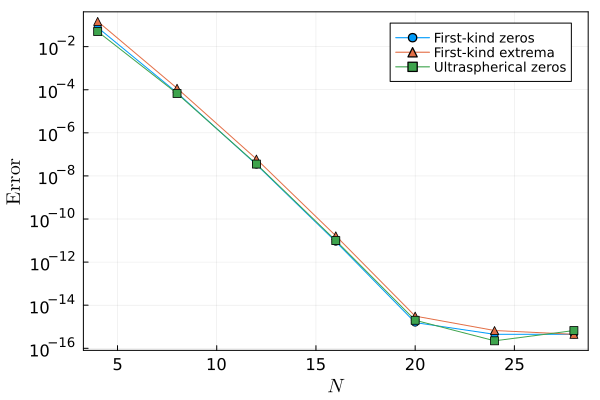

In [50]:
p = plot()
for i = 1:3
    plot!(p,ns,errs[:,i], yaxis = :log,
        label = gridlabels[i], framestyle = :box,
        marker = gridsymb[i], yticks = [10.0^(-2i) for i = -2:8], ylabel = latexstring("\\mathrm{Error}"),
        xlabel = L"N";fontargs...)
end
savefig(p,"../first-order.pdf")
p

Solve

$$ -\frac{d^2 u}{dx^2} - 25 u(x) = 0, \quad u(-1) = 1, \quad u(1) = -1.$$

In [51]:
u = x -> - csc(5.0)*sin(5.0*x)

#155 (generic function with 1 method)

In [52]:
k = 2
gridfuns = [n -> Ugrid(n-k); n -> Tgrid(n-k); n -> Pgrid(k,n-k)]
gridlabels = ["First-kind zeros"; "First-kind extrema"; "Ultraspherical zeros"]
gridsymb = [:circle; :utriangle; :square]
testgrid = -1:0.01:1
ns = 4:4:30
errs = zeros(length(ns),3)
for j = 1:3
    for i = 1:length(ns)
        n = ns[i]
        grid = gridfuns[j](n);
        A = -poly(2.0,n,grid)*Diff(1.0,n)*Diff(0.0,n) - 25*poly(0.0,n,grid);
        a = fill(0.0,n-k)
        B = poly(0.0,n,[-1.0,1.0]);
        b = [1;-1]
        z = vcat(fill(1.0,k),-diag(Diff(1.0,n)*Diff(0.0,n),k))
        Z = Diagonal(z)
        Z = I # Don't right-precondition
        idK = vcat(B,A)*inv(Z)
        un = UltraFun(0.0,Z\(idK\vcat(b,a)));
        errs[i,j] = maximum(abs.(u.(testgrid) - un.(testgrid)))
    end
end

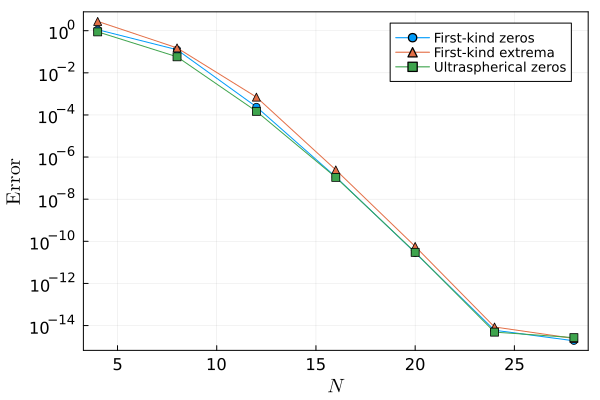

In [53]:
p = plot()
for i = 1:3
    plot!(p,ns,errs[:,i], yaxis = :log, label = gridlabels[i], framestyle = :box,
        marker = gridsymb[i], yticks = [10.0^(-2i) for i = -2:8], ylabel = latexstring("\\mathrm{Error}"),
    xlabel = L"N";fontargs...)
end
savefig(p,"../second-order.pdf")
p

Solve

$$ -\frac{d^3 u}{dx^3} - 10000xu(x) = 0, \quad u(-1) = 1, \quad u(1) = -1, \quad u'(-1) = 0.$$

In [54]:
n = 500;
grid = Ugrid(n - 3);
A = -poly(3.0,n,grid)*(Diff(2.0,n)*Diff(1.0,n)*Diff(0.0,n)) - 10000*Diagonal(grid)*poly(0.0,n,grid);
B = poly(0.0,n,[-1.0,1.0]);
C = poly(1.0,n,[-1])*Diff(0.0,n)
u = UltraFun(0.0,vcat(A,B,C)\(e(n-2,n) - e(n-1,n)));

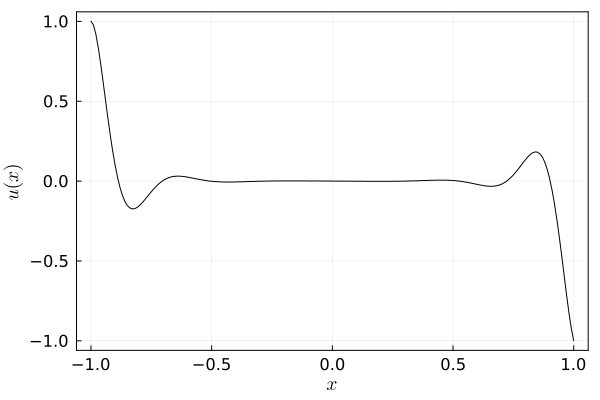

In [55]:
p = plot(testgrid,u.(testgrid), framestyle = :box, color = :black, legend = false, ylabel = L"u(x)", xlabel = L"x";fontargs...);
savefig(p,"../u-third-order.pdf")
p

In [56]:
k = 3
gridfuns = [n -> Ugrid(n-k); n -> Tgrid(n-k); n -> Pgrid(k,n-k)]
gridlabels = ["First-kind zeros"; "First-kind extrema"; "Ultraspherical zeros"]
gridsymb = [:circle; :utriangle; :square]
testgrid = -1:0.01:1
ns = 5:5:80
errs = zeros(length(ns),3)
for j = 1:3
    for i = 1:length(ns)
        n = ns[i]
        grid = gridfuns[j](n);
        A = -poly(3.0,n,grid)*(Diff(2.0,n)*Diff(1.0,n)*Diff(0.0,n)) - 10000*Diagonal(grid)*poly(0.0,n,grid);
        B = poly(0.0,n,[-1.0,1.0]);
        C = poly(1.0,n,[-1])*Diff(0.0,n)
        a = fill(0.0,n-k)
        b = [1;-1]
        c = [0]
        z = vcat(fill(1.0,k),-diag(Diff(2.0,n)*Diff(1.0,n)*Diff(0.0,n),k))
        Z = Diagonal(z)
        Z = I # Don't right-precondition
        idK = vcat(C,B,A)*inv(Z)
        un = UltraFun(0.0,Z\(idK\vcat(c,b,a)));
        errs[i,j] = maximum(abs.(u.(testgrid) - un.(testgrid)))
    end
end

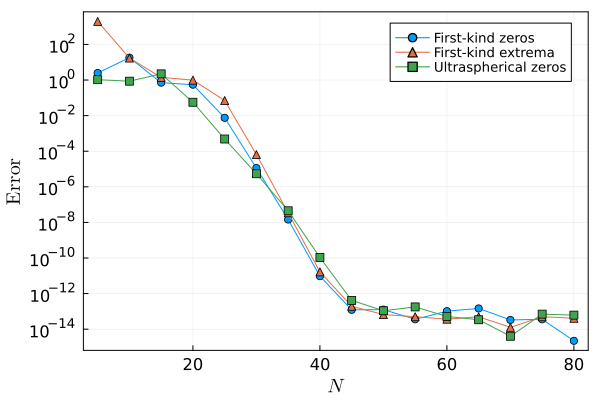

In [57]:
p = plot()
for i = 1:3
    plot!(p,ns,errs[:,i], yaxis = :log, label = gridlabels[i], framestyle = :box,
        marker = gridsymb[i], yticks = [10.0^(-2i) for i = -2:8], ylabel = latexstring("\\mathrm{Error}"),
    xlabel = L"N";fontargs...)
end
savefig(p,"../third-order.pdf")
p

Solve

$$ \epsilon \frac{d^2 u}{dx^2} + \frac{d u}{dx} + u  = 0, \quad u(-1) = 0, \quad u(1) = 1.$$

In [58]:
n = 1000;
grid = Ugrid(n - 2);
ϵ = 1e-3
A = ϵ*poly(2.0,n,grid)*(Diff(1.0,n)*Diff(0.0,n)) + poly(1.0,n,grid)*(Diff(0.0,n)) + poly(0.0,n,grid);
B = poly(0.0,n,[-1.0,1.0]);
u = UltraFun(0.0,vcat(A,B)\(e(n,n)));

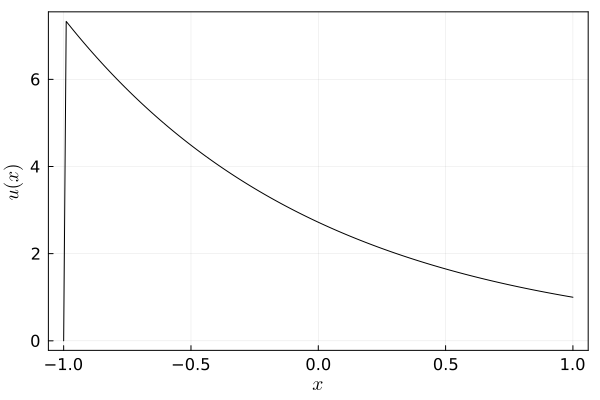

In [59]:
p = plot(testgrid,u.(testgrid), framestyle = :box, color = :black,
    legend = false, ylabel = L"u(x)", xlabel = L"x";fontargs...);
savefig(p,"../u-boundary-layer.pdf")
p

In [60]:
k = 2
gridfuns = [n -> Ugrid(n-k); n -> Tgrid(n-k); n -> Pgrid(k,n-k)]
gridlabels = ["First-kind zeros"; "First-kind extrema"; "Ultraspherical zeros"]
gridsymb = [:circle; :utriangle; :square]
testgrid = -1:0.01:1
ns = 5:20:400
errs = zeros(length(ns),3)
for j = 1:3
    for i = 1:length(ns)
        n = ns[i]
        grid = gridfuns[j](n);
        A = ϵ*poly(2.0,n,grid)*(Diff(1.0,n)*Diff(0.0,n)) + poly(1.0,n,grid)*(Diff(0.0,n)) + poly(0.0,n,grid);
        a = fill(0.0,n-k)
        B = poly(0.0,n,[-1.0,1.0]);
        b = [0.0;1.0]
        z = vcat(fill(1.0,k),diag(ϵ*Diff(1.0,n)*Diff(0.0,n),k))
        Z = Diagonal(z)
        Z = I # Don't right-precondition
        idK = vcat(B,A)*inv(Z)
        un = UltraFun(0.0,Z\(idK\vcat(b,a)));
        errs[i,j] = maximum(abs.(u.(testgrid) - un.(testgrid)))
    end
end

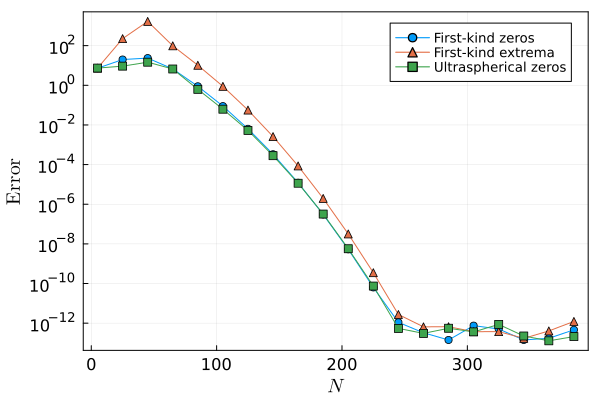

In [61]:
p = plot()
for i = 1:3
    plot!(p,ns,errs[:,i], yaxis = :log, label = gridlabels[i], framestyle = :box,
        marker = gridsymb[i], yticks = [10.0^(-2i) for i = -2:8], ylabel = latexstring("\\mathrm{Error}"),
    xlabel = L"N";fontargs...)
end
savefig(p,"../boundary-layer.pdf")
p

Solve

$$ \epsilon^3 \frac{d^2 u}{dx^2} - x u(x) = 0, \quad u(-1) = {\rm Ai}(-1/\epsilon), \quad u(1) = {\rm Ai}(1/\epsilon).$$

In [62]:
ϵ = .01
u = x -> airyai(x/ϵ)

#181 (generic function with 1 method)

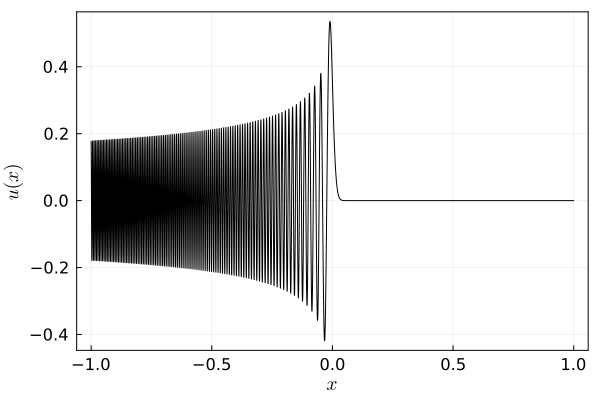

In [63]:
finegrid = -1:.0001:1
p = plot(finegrid,u.(finegrid), framestyle = :box, 
    legend = false, color = :black, ylabel = L"u(x)", xlabel = L"x";fontargs...);
savefig(p,"../u-airy.pdf")
p

In [64]:
k = 2
gridfuns = [n -> Ugrid(n-k); n -> Tgrid(n-k); n -> Pgrid(k,n-k)]
gridlabels = ["First-kind zeros"; "First-kind extrema"; "Ultraspherical zeros"]
gridsymb = [:circle; :utriangle; :square]
testgrid = -1:0.01:1
ns = 5:50:1000
errs = zeros(length(ns),3)
for j = 1:3
    for i = 1:length(ns)
        n = ns[i]
        grid = gridfuns[j](n);
        A = ϵ^3*poly(2.0,n,grid)*(Diff(1.0,n)*Diff(0.0,n)) -  Diagonal(grid)*poly(0.0,n,grid);
        B = poly(0.0,n,[-1,1]);
        a = fill(0.0,n-k)
        b = [u(-1);u(1)]
        z = vcat(fill(1.0,k),diag(ϵ^3*Diff(1.0,n)*Diff(0.0,n),k))
        Z = Diagonal(z)
        Z = I # Don't right-precondition
        idK = vcat(B,A)*inv(Z)
        un = UltraFun(0.0,Z\(idK\vcat(b,a)));
        errs[i,j] = maximum(abs.(u.(testgrid) - un.(testgrid)))
    end
end

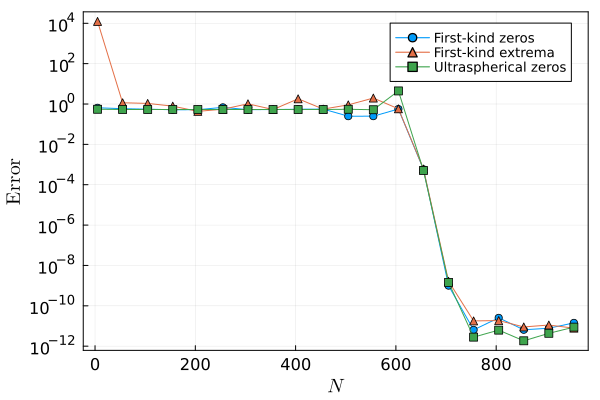

In [65]:
p = plot()
for i = 1:3
    plot!(p,ns,errs[:,i], yaxis = :log, label = gridlabels[i], framestyle = :box,
        marker = gridsymb[i], yticks = [10.0^(-2i) for i = -2:8], ylabel = latexstring("\\mathrm{Error}"),
    xlabel = L"N";fontargs...)
end
savefig(p,"../airy.pdf")
p

In [66]:
k = 2
gridfuns = [(n,λ) -> Pgrid(k + λ,n-k); (n,λ) -> Pgrid(k + λ,n-k); (n,λ) -> Pgrid(k + λ,n-k)]
gridlabels = [0; 0.5; 1.0]
gridsymb = [:circle; :utriangle; :square]
testgrid = -1:0.01:1
ns = 50:50:1000
errs = zeros(length(ns),3)
for j = 1:3
    for i = 1:length(ns)
        n = ns[i]
        λ = gridlabels[j]
        grid = gridfuns[j](n,λ);
        A = ϵ^3*poly(2.0 + λ,n,grid)*(Diff(1.0 + λ,n)*Diff(0.0 + λ,n)) -  Diagonal(grid)*poly(0.0 + λ,n,grid);
        B = poly(0.0 + λ,n,[-1,1]);
        a = fill(0.0,n-k)
        b = [u(-1);u(1)]
        z = vcat(fill(1.0,k),diag(ϵ^3*Diff(1.0 + λ,n)*Diff(0.0 + λ,n),k))
        Z = Diagonal(z)
        Z = I # Don't right-precondition
        idK = vcat(B,A)*inv(Z)
        un = UltraFun(0.0 + λ,Z\(idK\vcat(b,a)));
        errs[i,j] = maximum(abs.(u.(testgrid) - un.(testgrid)))
    end
end

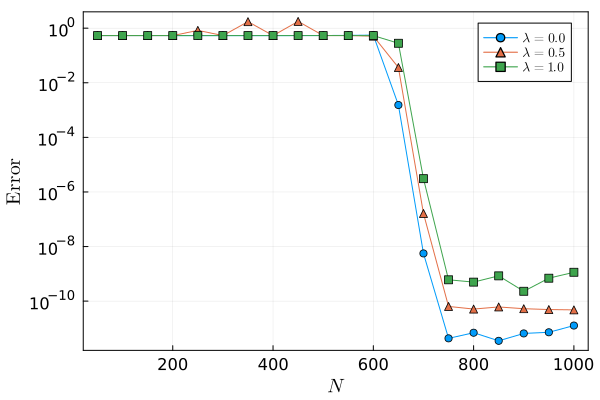

In [67]:
p = plot()
for i = 1:3
    plot!(p,ns,errs[:,i], yaxis = :log,
        label = latexstring(@sprintf("\\lambda = %1.1f",gridlabels[i])),
        framestyle = :box,
        marker = gridsymb[i], yticks = [10.0^(-2i) for i = -2:8], ylabel = latexstring("\\mathrm{Error}"),
    xlabel = L"N";fontargs...)
end
savefig(p,"../airy-lambda.pdf")
p

Solve

$$ \frac{d^2 u}{dx^2} + |x| u(x) = \left(|x|-\frac{\pi^2}{4}\right)\sin(\pi x /2), \quad u(-1) = -1, \quad u(1) = 1.$$

In [68]:
un = 0

0

In [69]:
u = x -> sin(pi*x/2)

#199 (generic function with 1 method)

In [70]:
k = 2
gridfuns = [n -> Ugrid(n-k); n -> Tgrid(n-k); n -> Pgrid(k,n-k)]
gridlabels = ["First-kind zeros"; "First-kind extrema"; "Ultraspherical zeros"]
gridsymb = [:circle; :utriangle; :square]
testgrid = -1:0.01:1
ns = 4:2:18
errs = zeros(length(ns),3)
for j = 1:3
    for i = 1:length(ns)
        n = ns[i]
        grid = gridfuns[j](n);
        A = poly(2.0,n,grid)*(Diff(1.0,n)*Diff(0.0,n)) +
            Diagonal(abs.(grid))*poly(0.0,n,grid);
        B = poly(0.0,n,[-1,1]);
        a = (abs.(grid) .- pi^2/4).*sin.(pi*grid/2)
        b = [-1;1]
        un = UltraFun(0.0,vcat(A,B)\vcat(a,b));
        errs[i,j] = maximum(abs.(u.(testgrid) - un.(testgrid)))
    end
end

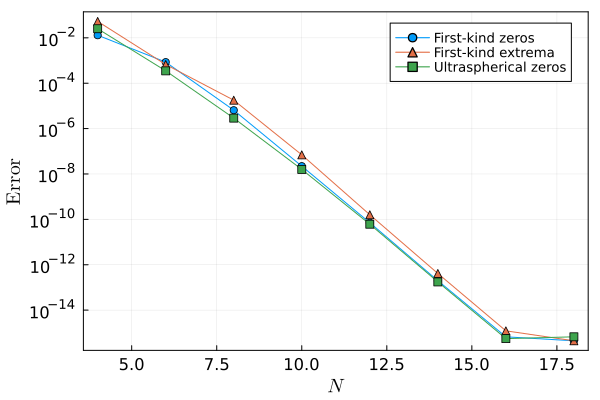

In [71]:
p = plot()
for i = 1:3
    plot!(p,ns,errs[:,i], yaxis = :log, label = gridlabels[i], framestyle = :box,
        marker = gridsymb[i], yticks = [10.0^(-2i) for i = -2:8], ylabel = latexstring("\\mathrm{Error}"),
    xlabel = L"N";fontargs...)
end
savefig(p,"../abs.pdf")
p

# GMRES testing

Solve

$$\epsilon\frac{d^2 u}{dx^2} + \frac{d u}{dx} + u  = 0, \quad u(-1) = 0, \quad u(1) = 1.$$

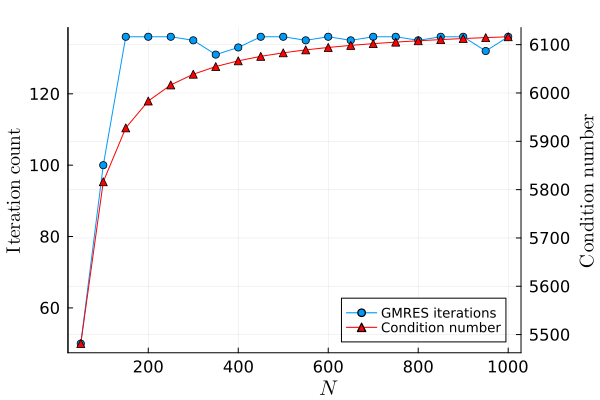

20-element Vector{Float64}:
  50.0
 100.0
 136.0
 136.0
 136.0
 135.0
 131.0
 133.0
 136.0
 136.0
 135.0
 136.0
 135.0
 136.0
 136.0
 135.0
 136.0
 136.0
 132.0
 136.0

In [81]:
ns = 50:50:1000
data = zeros(length(ns),2)
for i = 1:length(ns)
    n = ns[i]
    k = 2
    grid = Pgrid(k,n-k);
    ϵ = 0.05
    A = ϵ*poly(2.0,n,grid)*(Diff(1.0,n)*Diff(0.0,n)) + poly(1.0,n,grid)*(Diff(0.0,n)) + Diagonal(sin.(10*grid))*poly(0.0,n,grid);
    a = zeros(n-k)
    B = poly(1.0,n,[-1.0,1.0])*Diff(0.0,n);
    b = [0;1]
    Z = zeros(n,n)
    Z[1:k,1:k] += I
    Z[k+1:end,:] += ϵ*(Diff(1.0,n)*Diff(0.0,n))[1:end-k,:]
    Z = Diagonal(Z)
    s = 1
    Δ = Diagonal([j^s for j=1:n])
    L = zeros(n,n)
    L[1:k,1:k] += I
    L[k+1:end,k+1:end] = PTransform(k,n-k);
    idK = Δ*L*vcat(B,A)*inv(Z)*inv(Δ)
    r = Δ*L*vcat(b,a);
    x, history = gmres(idK,r;log=true,reltol = 1e-14)
    y = Δ\(Z\x)
    data[i,1] = history.data[:resnorm] |> length
    data[i,2] = cond(idK)
end
p = plot(ns,data[:,1],marker = :circle, framestyle = :box, label = "GMRES iterations",
    legend = :bottomright,ylabel = latexstring("\\mathrm{Iteration~count}");fontargs...)
plot!(ns, NaN.*(1:10), framestyle=:box,label = "Condition number", linecolor=:red,
    marker = :utriangle, color = :red,top_margin=5mm;fontargs...) 
plot!(twinx(),ns,data[:,2],marker = :utriangle, color = :red,
    framestyle = :box,legend = (100,5800), top_margin=5mm, 
    ylabel = latexstring("\\mathrm{Condition~number}"), grid = true, left_margin = 5mm,bottom_margin = 10mm;fontargs...)
annotate!(600,5390,L"N")
savefig(p,"../precond-neumann.pdf")
p |> display
data[:,1]

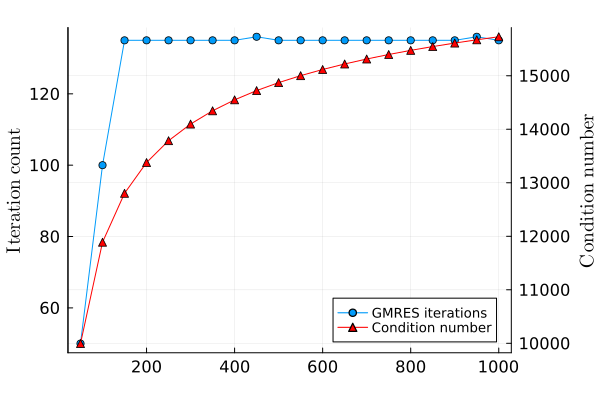

20-element Vector{Float64}:
  50.0
 100.0
 135.0
 135.0
 135.0
 135.0
 135.0
 135.0
 136.0
 135.0
 135.0
 135.0
 135.0
 135.0
 135.0
 135.0
 135.0
 135.0
 136.0
 135.0

In [82]:
ns = 50:50:1000
data = zeros(length(ns),2)
for i = 1:length(ns)
    n = ns[i]
    k = 2
    grid = Pgrid(k,n-k);
    ϵ = 0.05
    A = ϵ*poly(2.0,n,grid)*(Diff(1.0,n)*Diff(0.0,n)) + poly(1.0,n,grid)*(Diff(0.0,n)) + Diagonal(sin.(10*grid))*poly(0.0,n,grid);
    a = zeros(n-k)
    B = poly(1.0,n,[-1.0,1.0])*Diff(0.0,n);
    b = [0;1]
    Z = zeros(n,n)
    Z[1:k,1:k] += I
    Z[k+1:end,:] += ϵ*(Diff(1.0,n)*Diff(0.0,n))[1:end-k,:]
    Z = Diagonal(Z)
    s = 2/3
    Δ = Diagonal([j^s for j=1:n])
    L = zeros(n,n)
    L[1:k,1:k] += I
    L[k+1:end,k+1:end] = PTransform(k,n-k);
    idK = Δ*L*vcat(B,A)*inv(Z)*inv(Δ)
    r = Δ*L*vcat(b,a);
    x, history = gmres(idK,r;log=true,reltol = 1e-14)
    y = Δ\(Z\x)
    data[i,1] = history.data[:resnorm] |> length
    data[i,2] = cond(idK)
end
p = plot(ns,data[:,1],marker = :circle, framestyle = :box, label = "GMRES iterations",
    legend = :bottomright,ylabel = latexstring("\\mathrm{Iteration~count}");fontargs...)
plot!(ns, NaN.*(1:10), framestyle=:box,label = "Condition number", linecolor=:red,
    marker = :utriangle, color = :red,top_margin=5mm;fontargs...) 
plot!(twinx(),ns,data[:,2],marker = :utriangle, color = :red,
    framestyle = :box,legend = (100,5800), top_margin=5mm, 
    ylabel = latexstring("\\mathrm{Condition~number}"), grid = true, left_margin = 5mm,bottom_margin = 10mm;fontargs...)
annotate!(600,5390,L"N")
p |> display
data[:,1]

In [73]:
p = plot(abs.(y), yaxis = :log, xaxis = [0,250], framestyle = :box, color = :black, legend = false,
    ylabel = latexstring("\\mathrm{Coefficient~modulus}"),
    xlabel = latexstring("\\mathrm{Coefficient~index}");fontargs...)
savefig(p,"../coefs.pdf")
p

LoadError: UndefVarError: `y` not defined

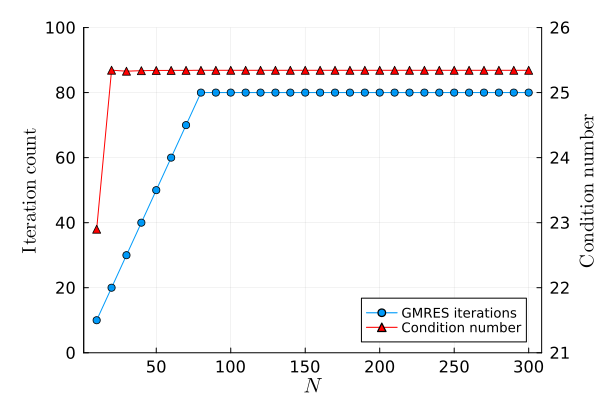

In [80]:
ns = 10:10:300
data = zeros(length(ns),2)
for i = 1:length(ns)
    n = ns[i]
    k = 2
    grid = Pgrid(k,n-k);
    ϵ = 0.05
    A = ϵ*poly(2.0,n,grid)*(Diff(1.0,n)*Diff(0.0,n)) + poly(1.0,n,grid)*(Diff(0.0,n)) + Diagonal(sin.(10*grid))*poly(0.0,n,grid);
    a = zeros(n-k)
    B = poly(0.0,n,[-1.0,1.0]);
    b = [0;1]
    Z = zeros(n,n)
    Z[1:k,1:k] += I
    Z[k+1:end,:] += ϵ*(Diff(1.0,n)*Diff(0.0,n))[1:end-k,:]
    Z = Diagonal(Z)
    s = 0
    Δ = Diagonal([j^s for j=1:n])
    L = zeros(n,n)
    L[1:k,1:k] += I
    L[k+1:end,k+1:end] = PTransform(k,n-k);
    idK = Δ*L*vcat(B,A)*inv(Z)*inv(Δ)
    r = Δ*L*vcat(b,a);
    x, history = gmres(idK,r;log=true,reltol = 1e-14)
    y = Δ\(Z\x)
    data[i,1] = history.data[:resnorm] |> length
    data[i,2] = cond(idK)
end
p = plot(ns,data[:,1],marker = :circle, framestyle = :box, label = "GMRES iterations",
    legend = :bottomright,yaxis = [0,100], left_margin=5mm, ylabel = latexstring("\\mathrm{Iteration~count}");fontargs...)
plot!(ns, NaN.*ns, framestyle=:box,label = "Condition number",
    linecolor=:red, marker = :utriangle, color = :red,top_margin=5mm;fontargs...) 
plot!(twinx(),ns,data[:,2],marker = :utriangle, color = :red,
    framestyle = :box, legend = false, yaxis= [21,26],
   left_margin=5mm, bottom_margin = 10mm, ylabel = latexstring("\\mathrm{Condition~number}"),
    grid = true;fontargs...)
annotate!(155,-10,L"N")
savefig(p,"../precond-dirichlet.pdf")
p

In [366]:
data

30×2 Matrix{Float64}:
 10.0  22.8993
 20.0  25.3445
 30.0  25.329
 40.0  25.3373
 50.0  25.3402
 60.0  25.3415
 70.0  25.3422
 80.0  25.3425
 80.0  25.3428
 80.0  25.3429
 80.0  25.343
 80.0  25.3431
 80.0  25.3431
  ⋮    
 80.0  25.3432
 80.0  25.3432
 80.0  25.3432
 80.0  25.3432
 80.0  25.3432
 80.0  25.3433
 80.0  25.3433
 80.0  25.3433
 80.0  25.3433
 80.0  25.3433
 80.0  25.3433
 80.0  25.3433

In [171]:
ϵ = 1.0
u = x -> airyai(x/ϵ)

#311 (generic function with 1 method)

GKS: Possible loss of precision in routine SET_WINDOW


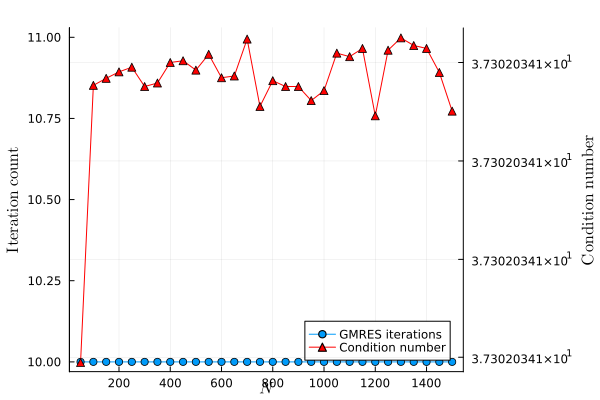

In [172]:
ns = 50:50:1500
data = zeros(length(ns),2)
for i = 1:length(ns)
    n = ns[i]
    k = 2
    grid = Pgrid(k,n-k);
    A = ϵ^3*poly(2.0,n,grid)*(Diff(1.0,n)*Diff(0.0,n)) -  Diagonal(grid)*poly(0.0,n,grid);
    B = poly(0.0,n,[-1,1]);
    a = zeros(n-k)
    b = [u(-1);u(1)]
    Z = zeros(n,n)
    Z[1:k,1:k] += I
    Z[k+1:end,:] += ϵ^3*(Diff(1.0,n)*Diff(0.0,n))[1:end-k,:]
    Z = Diagonal(Z)
    s = 2
    Δ = Diagonal([j^s for j=1:n])
    L = zeros(n,n)
    L[1:k,1:k] += I
    L[k+1:end,k+1:end] = PTransform(k,n-k);
    idK = Δ*L*vcat(B,A)*inv(Z)*inv(Δ)
    r = Δ*L*vcat(b,a);
    x, history = gmres(idK,r;log=true,reltol = 1e-14)
    y = Δ\(Z\x)
    data[i,1] = history.data[:resnorm] |> length
    data[i,2] = cond(idK)
end
p = plot(ns,data[:,1],marker = :circle, framestyle = :box, label = "GMRES iterations",
    legend = :bottomright,ylabel = latexstring("\\mathrm{Iteration~count}"))
plot!(ns, NaN.*(1:10), framestyle=:box,label = "Condition number", linecolor=:red, marker = :utriangle, color = :red,top_margin=5mm) 
plot!(twinx(),ns,data[:,2],marker = :utriangle, color = :red, framestyle = :box,legend = (100,5800),
    xlabel = L"N", top_margin=5mm, ylabel = latexstring("\\mathrm{Condition~number}"), grid = true)
savefig(p,"../precond-airy.pdf")
p